In [2]:
# %matplotlib ipympl
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as imageio
from skimage.draw import disk
# import helper_functions
import scipy.ndimage as ndimagey
import re
from multiprocessing import Pool

# helper_functions.set_style(shift=-8)

In [4]:
#My function

import SimpleITK as sitk
import numpy as np

def save_nifti(array, filename):
    """
    Save a 2D or 3D NumPy array as a NIFTI file using SimpleITK.

    Parameters:A
    - array: NumPy array (2D or 3D) to be saved.
    - filename: Path to the NIFTI file where the array will be saved.
    """
    # Convert NumPy array to SimpleITK image
    image = sitk.GetImageFromArray(array)
    
    # Save the image as a NIFTI file
    sitk.WriteImage(image, filename)
    
import SimpleITK as sitk

def load_nifti(filename):
    """
    Load a NIFTI file and convert it to a NumPy array using SimpleITK.

    Parameters:
    - filename: Path to the NIFTI file to be loaded.

    Returns:
    - NumPy array representation of the NIFTI file.
    """
    # Read the NIFTI file into a SimpleITK image
    image = sitk.ReadImage(filename)
    
    # Convert the SimpleITK image to a NumPy array
    array = sitk.GetArrayFromImage(image)
    
    return array


In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
import cupy as cp
import cupyx.scipy.ndimage as cu_ndimage
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

# Creates the rotation matrix and translation vector
# I arrived at this through a mix of trail and error and StackOverflow
def create_ridgid_transform(transform_params, center_of_rotation):
    R = nib.eulerangles.euler2mat(transform_params[2],
                                  transform_params[1],
                                  transform_params[0])
    R = np.linalg.inv(R)
    c = np.asarray(center_of_rotation)
    t = np.asarray([transform_params[5], transform_params[4], transform_params[3]])
    offset = -(c - c.dot(R)).dot(np.linalg.inv(R))
    T = t + offset

    return R, T

# It is much faster to use GPU compared to CPU
def rigid_transform_gpu(arr, R, T, gpu_idx=0, cval=0):
    with cp.cuda.Device(gpu_idx):
        tmp = cu_ndimage.affine_transform(cp.asarray(arr), cp.asarray(R),
                                          offset=cp.asarray(T), output_shape=arr.shape,
                                          mode='constant', cval=cval).get()
        mempool.free_all_blocks()
    return tmp

def colorbar(mappable, title=None, format=None, shift=None):
    if shift is not None:
        set_style(shift)
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, format=format)
    plt.sca(last_axes)
    if title is not None:
        cbar.set_label(title)
    return cbar

In [6]:
#My function

import SimpleITK as sitk
import numpy as np

def save_as_nifti(array, filename):
    """
    Save a 2D or 3D NumPy array as a NIFTI file using SimpleITK.

    Parameters:A
    - array: NumPy array (2D or 3D) to be saved.
    - filename: Path to the NIFTI file where the array will be saved.
    """
    # Convert NumPy array to SimpleITK image
    image = sitk.GetImageFromArray(array)
    
    # Save the image as a NIFTI file
    sitk.WriteImage(image, filename)


In [7]:
# Read the transformation parameters and the center of rotation from the output of Elastix.

file_path = r'C:\Users\awias\Documents\Research_Assistant\MicroCracks\Elastix\Outputs\\'
transform_params_pattern = re.compile(r'\(TransformParameters (.+?)\)')
center_of_rotation_pattern = re.compile(r'\(CenterOfRotationPoint (.+?)\)')


In [8]:
center_of_rotation_pattern

re.compile(r'\(CenterOfRotationPoint (.+?)\)', re.UNICODE)

In [14]:
with open(file_path+'TransformParameters.0.txt') as f:
    print(f'Opening file {file_path}TransformParameters.0.txt')
    text = f.read().replace('\n', '')
    

Opening file C:\Users\awias\Documents\Research_Assistant\MicroCracks\Elastix\Outputs\\TransformParameters.0.txt


In [16]:
# Extract TransformParameters
transform_params_match = transform_params_pattern.search(text)
if transform_params_match:
    transform_params = list(map(float, transform_params_match.group(1).split()))
    print("Transform Parameters:", transform_params)

# Extract CenterOfRotationPoint
center_of_rotation_match = center_of_rotation_pattern.search(text)
if center_of_rotation_match:
    center_of_rotation = list(map(float, center_of_rotation_match.group(1).split()))
    print("Center of Rotation Point:", center_of_rotation)

Transform Parameters: [0.128258, 0.43435, 0.092604, -1.668963, -5.836345, -2.782406]
Center of Rotation Point: [-22.5, -61.0, 15.0]


In [22]:
#Load moved object
filepath = r"D:\MicroCracks\pRESSURE\NIFTI\Pressure_tests_Scan_2_65_recon_cropped.nii"
moved_volume = load_nifti(filepath)

In [24]:
# Create and apply the transformation

R, T = create_ridgid_transform(transform_params, center_of_rotation)
print(R, T)

rotated_volume = rigid_transform_gpu(moved_volume, R, T, gpu_idx=0)

[[ 0.90325694  0.14530732 -0.40374829]
 [-0.08388513  0.98255936  0.16595299]
 [ 0.42082085 -0.11602972  0.89969268]] [  9.96084582 -11.27693457   2.22630312]


In [25]:
rotated_volume.shape

(31, 123, 46)

In [26]:
filepath = r"D:\MicroCracks\pRESSURE\NIFTI\Pressure_tests_Scan_2_5_recon_cropped.nii"
original_volume = load_nifti(filepath)

In [30]:
np.max(original_volume)

34314.0

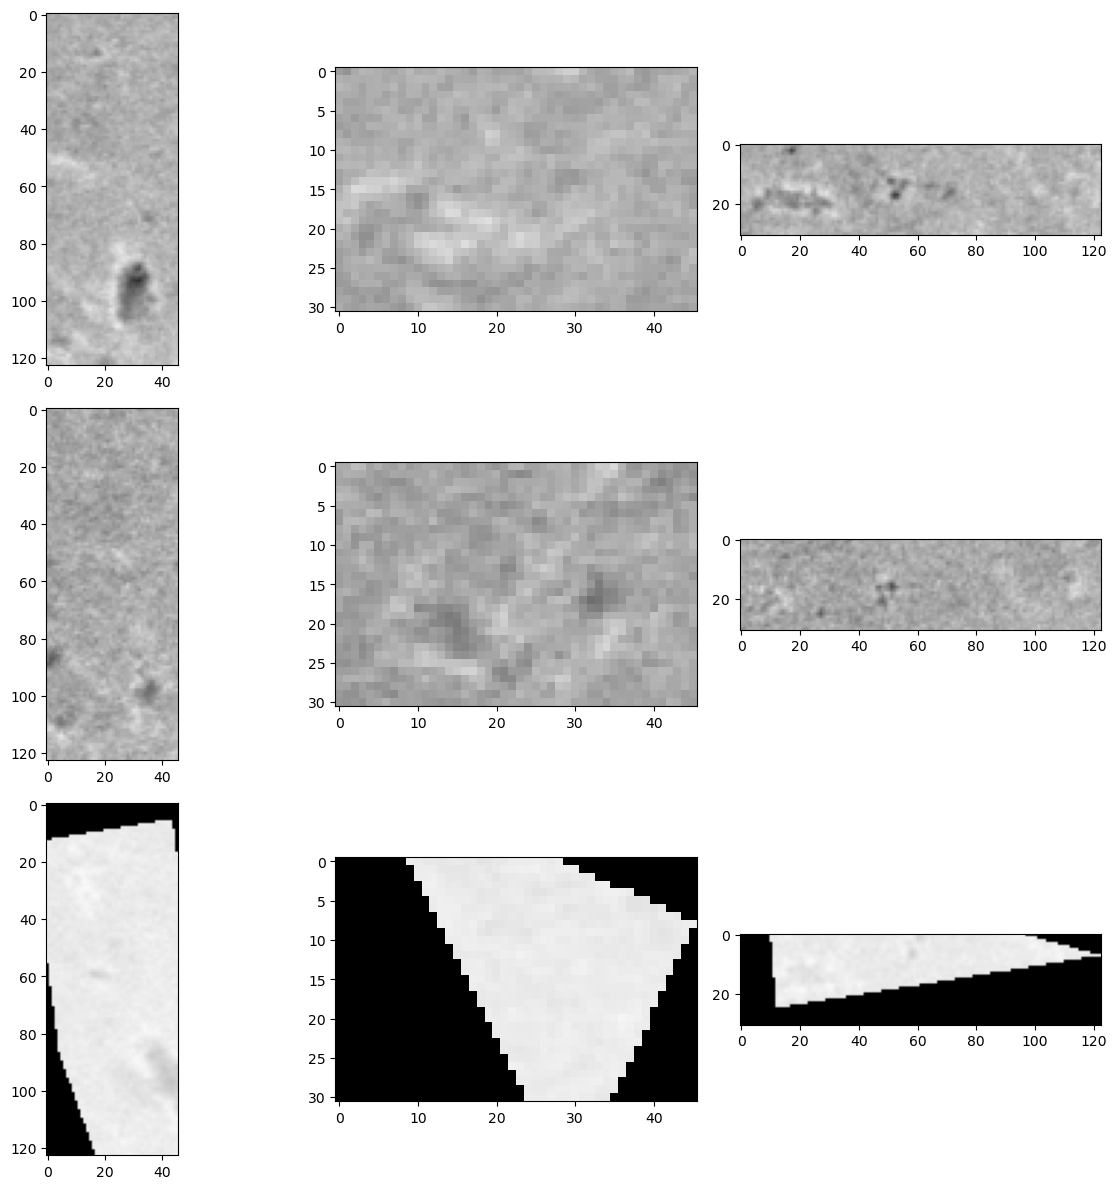

In [33]:
# Results

fig, ax = plt.subplots(3, 3, squeeze=False, figsize=(12, 12))
ax[0, 0].imshow(original_volume[10], vmin=np.min(original_volume), vmax=np.max(original_volume), cmap='gray')
ax[0, 1].imshow(original_volume[:, 10], vmin=np.min(original_volume), vmax=np.max(original_volume), cmap='gray')
ax[0, 2].imshow(original_volume[:, :, 10], vmin=np.min(original_volume), vmax=np.max(original_volume), cmap='gray')
ax[1, 0].imshow(moved_volume[10], vmin=np.min(moved_volume), vmax=np.max(moved_volume), cmap='gray')
ax[1, 1].imshow(moved_volume[:, 10], vmin=np.min(moved_volume), vmax=np.max(moved_volume), cmap='gray')
ax[1, 2].imshow(moved_volume[:, :, 10], vmin=np.min(moved_volume), vmax=np.max(moved_volume), cmap='gray')
ax[2, 0].imshow(rotated_volume[10], vmin=np.min(rotated_volume), vmax=np.max(rotated_volume), cmap='gray')
ax[2, 1].imshow(rotated_volume[:, 10], vmin=np.min(rotated_volume), vmax=np.max(rotated_volume), cmap='gray')
ax[2, 2].imshow(rotated_volume[:, :, 10], vmin=np.min(rotated_volume), vmax=np.max(rotated_volume), cmap='gray')
fig.tight_layout()

IndexError: index 500 is out of bounds for axis 0 with size 31

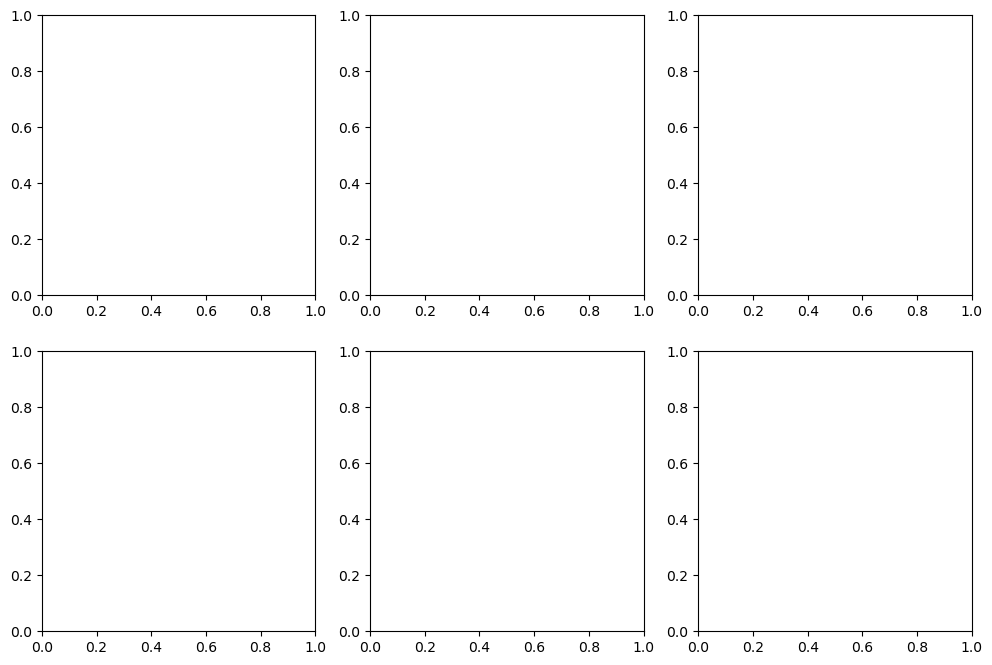

In [34]:
# More results, it's not quite perfect but pretty close.

fig, ax = plt.subplots(2, 3, squeeze=False, figsize=(12, 8))
# Difference before co-registration
ax[0, 0].imshow(original_volume[500].astype(np.float32) - moved_volume[500].astype(np.float32),
                vmin=-1e4, vmax=1e4, cmap='coolwarm')
ax[0, 1].imshow(original_volume[:, 500].astype(np.float32) - moved_volume[:, 500].astype(np.float32),
                vmin=-1e4, vmax=1e4, cmap='coolwarm')
ax[0, 2].imshow(original_volume[:, :, 500].astype(np.float32) - moved_volume[:, :, 500].astype(np.float32),
                vmin=-1e4, vmax=1e4, cmap='coolwarm')
# Difference after co-registration
ax[1, 0].imshow(original_volume[500].astype(np.float32) - rotated_volume[500].astype(np.float32),
                vmin=-1e4, vmax=1e4, cmap='coolwarm')
ax[1, 1].imshow(original_volume[:, 500].astype(np.float32) - rotated_volume[:, 500].astype(np.float32),
                vmin=-1e4, vmax=1e4, cmap='coolwarm')
ax[1, 2].imshow(original_volume[:, :, 500].astype(np.float32) - rotated_volume[:, :, 500].astype(np.float32),
                vmin=-1e4, vmax=1e4, cmap='coolwarm')
fig.tight_layout()